In [1]:
import numpy as np
import pandas as pd
from mat4py import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.utils import resample

import tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint
import sklearn
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization,Concatenate,concatenate, Input
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling1D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pickle

In [2]:
list_string=['ucddb002','ucddb003','ucddb005','ucddb006','ucddb007','ucddb009',\
             'ucddb010','ucddb012','ucddb014','ucddb015','ucddb017',\
             'ucddb019','ucddb020','ucddb021','ucddb022','ucddb023','ucddb024',\
             'ucddb025','ucddb026','ucddb027','ucddb028']#'ucddb008','ucddb011','ucddb013','ucddb014',


valid_features=np.zeros((1,1408))
test_features=np.zeros((1,1408))
valid_labels=np.zeros((1,1))
test_labels=np.zeros((1,1))
for l in list_string:
        
        
        ecg_valid = loadmat('D:\\CSE499\\files2\\'+l+'_ecg_valid.mat')
        ecg_valid = np.array(ecg_valid['ecg_valid'])
        ecg_valid_labels=loadmat('D:\\CSE499\\files2\\'+l+'_valid_labels.mat')
        ecg_valid_labels = np.array(ecg_valid_labels['class_valid'])
        valid_features=np.append(valid_features,ecg_valid,axis=0)
        valid_labels=np.append(valid_labels,ecg_valid_labels)
       
        
        ecg_test = loadmat('D:\\CSE499\\files2\\'+l+'_ecg_test.mat')
        ecg_test = np.array(ecg_test['ecg_test'])
        ecg_test_labels=loadmat('D:\\CSE499\\files2\\'+l+'_test_labels.mat')
        ecg_test_labels = np.array(ecg_test_labels['class_test'])
        test_features=np.append(test_features,ecg_test,axis=0)
        test_labels=np.append(test_labels,ecg_test_labels)
        
ecg_valid=valid_features[1:,:]
valid_labels=valid_labels[1:]
valid_labels = valid_labels.flatten()

ecg_test=test_features[1:,:]
test_labels=test_labels[1:]
test_labels = test_labels.flatten()

In [3]:
train_features=np.zeros((1,1408))

train_labels=np.zeros((1,1))

for l in list_string:
        ecg_train = loadmat('D:\\CSE499\\files2\\'+l+'_ecg_train.mat')
        ecg_train = np.array(ecg_train['ecg_train'])
        ecg_train_labels=loadmat('D:\\CSE499\\files2\\'+l+'_train_labels.mat')
        ecg_train_labels = np.array(ecg_train_labels['class_train'])
        train_features=np.append(train_features,ecg_train,axis=0)
        train_labels=np.append(train_labels,ecg_train_labels)
        
ecg_train=train_features[1:,:]

train_labels=train_labels[1:]
train_labels = train_labels.flatten()

In [4]:
ecg_train_mean=np.mean(ecg_train)
ecg_train_std=np.std(ecg_train)

In [5]:
for i in range(ecg_train.shape[0]):
    ecg_train[i,:]=(ecg_train[i,:]-ecg_train_mean)/ecg_train_std
    
for i in range(ecg_valid.shape[0]):
    ecg_valid[i,:]=(ecg_valid[i,:]-ecg_train_mean)/ecg_train_std
    
for i in range(ecg_test.shape[0]):
    ecg_test[i,:]=(ecg_test[i,:]-ecg_train_mean)/ecg_train_std
    

ecg_train=np.expand_dims(ecg_train, axis=2)
ecg_valid=np.expand_dims(ecg_valid, axis=2)
ecg_test=np.expand_dims(ecg_test, axis=2)

In [6]:
y_train=train_labels
y_valid=valid_labels
y_test=test_labels

In [7]:
tensorflow.keras.backend.clear_session()

In [8]:
num_classes=2

In [9]:
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = tensorflow.keras.utils.to_categorical(y_train_num, num_classes)

y_valid_num = y_train_encoder.fit_transform(y_valid)
y_valid_wide = tensorflow.keras.utils.to_categorical(y_valid_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = tensorflow.keras.utils.to_categorical(y_test_num, num_classes)

In [10]:
model_ecg = Sequential()
model_ecg.add(BatchNormalization(input_shape=(1408,1)))
model_ecg.add(Conv1D(3, kernel_size=(100),strides=2))
model_ecg.add(Activation("relu"))
model_ecg.add(MaxPooling1D(pool_size=(2),strides=2))
model_ecg.add(Conv1D(50, (10)))
model_ecg.add(MaxPooling1D(pool_size=(2),strides=2))
model_ecg.add(Activation("relu"))
model_ecg.add(Conv1D(30, (30)))
model_ecg.add(MaxPooling1D(pool_size=(2)))
model_ecg.add(Activation("relu"))
model_ecg.add(BatchNormalization())
model_ecg.add(Flatten())
model_ecg.add(Dropout(0.25))
model_ecg.add(Dense(2, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='softmax'))

model_ecg.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 1408, 1)          4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 655, 3)            303       
                                                                 
 activation (Activation)     (None, 655, 3)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 327, 3)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 318, 50)           1550      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 159, 50)          0

In [11]:
batch_size = 32
epochs = 30

opt = tensorflow.keras.optimizers.Adam(learning_rate = 0.001)
model_ecg.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [12]:
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [13]:
ecg_train.shape

(805926, 1408, 1)

In [14]:
best_weights_filepath_ecg = './best_weights_ecg_32layer.hdf5'

In [15]:
best_weights_filepath_ecg = './best_weights_ecg_32layer.hdf5'
mcp_ecg = ModelCheckpoint(best_weights_filepath_ecg, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)
            
history = model_ecg.fit(ecg_train, y_train_wide,
         batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(ecg_valid, y_valid_wide),
          callbacks=[mcp_ecg])

Epoch 1/30
25186/25186 [==============================] - 576s 23ms/step - loss: 0.1945 - accuracy: 0.9287 - val_loss: 0.1358 - val_accuracy: 0.9580
Epoch 2/30
25186/25186 [==============================] - 564s 22ms/step - loss: 0.0964 - accuracy: 0.9725 - val_loss: 0.0897 - val_accuracy: 0.9753
Epoch 3/30
25186/25186 [==============================] - 559s 22ms/step - loss: 0.0785 - accuracy: 0.9793 - val_loss: 0.0983 - val_accuracy: 0.9682
Epoch 4/30
25186/25186 [==============================] - 559s 22ms/step - loss: 0.0695 - accuracy: 0.9824 - val_loss: 0.0774 - val_accuracy: 0.9765
Epoch 5/30
25186/25186 [==============================] - 569s 23ms/step - loss: 0.0638 - accuracy: 0.9845 - val_loss: 0.0773 - val_accuracy: 0.9766
Epoch 6/30
25186/25186 [==============================] - 560s 22ms/step - loss: 0.0597 - accuracy: 0.9860 - val_loss: 0.0654 - val_accuracy: 0.9846
Epoch 7/30
25186/25186 [==============================] - 560s 22ms/step - loss: 0.0564 - accuracy: 0.9871

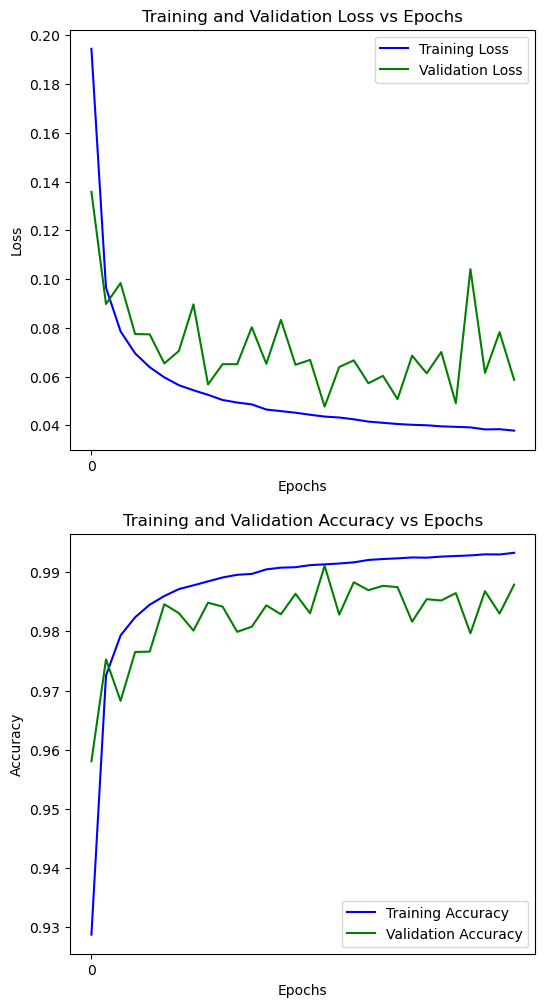

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

plt.figure(figsize=(6,12))

plt.subplot(2,1,1)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::100])
plt.title('Training and Validation Loss vs Epochs')
plt.legend()

plt.subplot(2,1,2)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(acc, 'blue', label='Training Accuracy')
plt.plot(val_acc, 'green', label='Validation Accuracy')
plt.xticks(range(0,epochs)[0::100])
plt.title('Training and Validation Accuracy vs Epochs')
plt.legend()
plt.savefig("plots_perf.svg")
plt.show()

In [18]:
model_ecg.load_weights('./best_weights_ecg_32layer.hdf5')
y_pred = model_ecg.predict(ecg_test)
predict_test=np.argmax(y_pred, axis=1)
predict_test=predict_test.reshape(predict_test.shape[0],1)
cm=confusion_matrix(y_test_num, predict_test)
cm

1617/1617 [==============================] - 4s 3ms/step


array([[49915,   453],
       [   59,  1309]], dtype=int64)

In [19]:
(cm[1,1]+cm[0,0])/(cm[1,1]+cm[1,0]+cm[0,0]+cm[0,1])

0.9901036029070667

In [20]:
cm[1,1]/(cm[1,1]+cm[1,0])

0.9568713450292398

In [21]:
cm[0,0]/(cm[0,0]+cm[0,1])

0.9910061944091486

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

model_ecg.load_weights('./best_weights_ecg_32layer.hdf5')
y_pred = model_ecg.predict(ecg_test)
predict_test = np.argmax(y_pred, axis=1)
predict_test = predict_test.reshape(predict_test.shape[0], 1)

# Confusion Matrix
cm = confusion_matrix(y_test_num, predict_test)
print("Confusion Matrix:")
print(cm)

# Precision, Recall, F1 Score
precision = precision_score(y_test_num, predict_test)
recall = recall_score(y_test_num, predict_test)
f1 = f1_score(y_test_num, predict_test)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

accuracy = (cm[1, 1] + cm[0, 0]) / (cm[1, 1] + cm[1, 0] + cm[0, 0] + cm[0, 1])
print(f"Accuracy: {accuracy}")

1617/1617 [==============================] - 5s 3ms/step
Confusion Matrix:
[[49915   453]
 [   59  1309]]
Precision: 0.742905788876277
Recall: 0.9568713450292398
F1 Score: 0.8364217252396167
Accuracy: 0.9901036029070667
